In [104]:
%pip install pm4py
%pip install pandas
%pip install numpy
import pm4py
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [121]:
import requests
import tempfile

## import the database

url = 'https://raw.githubusercontent.com/marianamr17/SepsisCase/main/Sepsis%20Cases%20-%20Event%20Log.xes'

try:
    # Fetch the file content from the URL
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses

    # Write the content to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.xes') as tmp_file:
        tmp_file.write(response.content)
        temp_file_path = tmp_file.name

    # Read the XES file using pm4py
    log = pm4py.read_xes(temp_file_path)

    # Optional: Inspect the first few events to understand the structure
    for event in log[0]:
        print(event)


except requests.exceptions.HTTPError as http_err:
    print(f'HTTP error occurred: {http_err}')  # Print HTTP error
except Exception as err:
    print(f'Other error occurred: {err}')  # Print any other error


parsing log, completed traces :: 100%|████| 1050/1050 [00:00<00:00, 4406.02it/s]


Other error occurred: 0


In [122]:


# Assuming your event log is loaded into log_df
# Convert event log to DataFrame
df = pm4py.convert_to_dataframe(log)

# Convert timestamps to datetime format
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
#df.info()  

# Number of events
num_events = len(df)
print(f"Number of events: {num_events}")

# Number of cases
num_cases = df['case:concept:name'].nunique()
print(f"Number of cases: {num_cases}")

# Convert DataFrame back to PM4Py event log for activity analysis
log = pm4py.convert_to_event_log(df)

# Get start and end activities
start_activities = pm4py.get_start_activities(log)
end_activities = pm4py.get_end_activities(log)

print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))


Number of events: 15214
Number of cases: 1050
Start activities: {'ER Registration': 995, 'IV Liquid': 14, 'ER Triage': 6, 'CRP': 10, 'ER Sepsis Triage': 7, 'Leucocytes': 18}
End activities: {'Release A': 393, 'Return ER': 291, 'IV Antibiotics': 87, 'Release B': 55, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'IV Liquid': 12, 'Release C': 19, 'CRP': 41, 'LacticAcid': 24, 'Release D': 14, 'Admission NC': 14, 'Release E': 5, 'ER Triage': 2}


In [123]:
#Incomplete cases - cases that start with er registration, er sepsis triage or er triage, but don't end with release a, b , c, d , e or return er

# Defining start and end activities
start_activities_list = ['ER Registration', 'ER Sepsis Triage', 'ER Triage']
end_activities_list = ['Release A', 'Release B', 'Release C', 'Release D', 'Release E', 'Return ER']

# Filtering cases by start activities
log_with_start_activities = pm4py.filter_start_activities(log, start_activities_list)

# Filtering cases that do not end with specified activities. (releases, or return er)
log_without_end_activities = pm4py.filter_end_activities(log_with_start_activities, end_activities_list, retain=False)

# Get the number of incomplete cases
incomplete_cases = len(set(trace.attributes['concept:name'] for trace in log_without_end_activities))

# Cleaned database, without incomplete cases
cleaned_log = pm4py.filter_end_activities(log_with_start_activities, end_activities_list, retain=True)

# Converting the filtered event log back to a DataFrame
cleaned_df = pm4py.convert_to_dataframe(cleaned_log)

# Get the number of complete cases
num_complete_cases = cleaned_df['case:concept:name'].nunique()

print(f"Given {num_cases} total cases in the log, we have {incomplete_cases} incomplete cases.")
print(f"After filtering out incomplete cases, we have {num_complete_cases} complete cases in our dataset.")

Given 1050 total cases in the log, we have 265 incomplete cases.
After filtering out incomplete cases, we have 743 complete cases in our dataset.


In [124]:
# Define a function to compute the case durations
def compute_case_duration(df):
    # Creating columns for the end and start date of each case
    df['End Date'] = df.groupby('case:concept:name')['time:timestamp'].transform('max')
    df['Start Date'] = df.groupby('case:concept:name')['time:timestamp'].transform('min')
    # Calculating the duration for each case
    df['Duration'] = df['End Date'] - df['Start Date']

    # Group by case id and get the duration
    case_durations = df.groupby('case:concept:name')['Duration'].first()
    return case_durations

# Compute the durations for the cleaned dataset
case_durations = compute_case_duration(cleaned_df)

# Calculate mean, median, mode, and standard deviation of the case durations
mean_duration = case_durations.mean()
median_duration = case_durations.median()
mode_duration = case_durations.mode().values[0] if not case_durations.mode().empty else None
std_duration = case_durations.std()

print("Mean Duration:", mean_duration)
print("Median Duration:", median_duration)
print("Mode Duration:", mode_duration)
print("Standard Deviation of Duration:", std_duration)


Mean Duration: 38 days 15:10:50.425302826
Median Duration: 9 days 06:41:11
Mode Duration: 11666000000000 nanoseconds
Standard Deviation of Duration: 67 days 19:26:58.950116386


In [125]:
# Outliers - cases with duration greater than mean + 3 * std deviation
outliers = case_durations[case_durations > mean_duration + 3 * std_duration]


# Print the number of outliers
num_outliers = len(outliers)
print(f"Number of outliers: {num_outliers}")


Number of outliers: 21


In [126]:
# Trim outliers
trimmed_durations = case_durations[case_durations <= mean_duration + 3 * std_duration]

# Recalculate statistics without outliers
mean_trimmed = trimmed_durations.mean()
median_trimmed = trimmed_durations.median()
mode_trimmed = trimmed_durations.mode().values[0] if not trimmed_durations.mode().empty else None
std_trimmed = trimmed_durations.std()

print("Trimmed Mean Duration:", mean_trimmed)
print("Trimmed Median Duration:", median_trimmed)
print("Trimmed Mode Duration:", mode_trimmed)
print("Trimmed Standard Deviation:", std_trimmed)

# dataframe without outliers
filtered_df = cleaned_df[cleaned_df['case:concept:name'].isin(trimmed_durations.index)]


Trimmed Mean Duration: 30 days 14:33:49.054016620
Trimmed Median Duration: 8 days 18:57:17
Trimmed Mode Duration: 11666000000000 nanoseconds
Trimmed Standard Deviation: 48 days 07:34:35.838001446


Start activities: {'ER Registration': 995, 'IV Liquid': 14, 'ER Triage': 6, 'CRP': 10, 'ER Sepsis Triage': 7, 'Leucocytes': 18}
End activities: {'Release A': 393, 'Return ER': 291, 'IV Antibiotics': 87, 'Release B': 55, 'ER Sepsis Triage': 49, 'Leucocytes': 44, 'IV Liquid': 12, 'Release C': 19, 'CRP': 41, 'LacticAcid': 24, 'Release D': 14, 'Admission NC': 14, 'Release E': 5, 'ER Triage': 2}


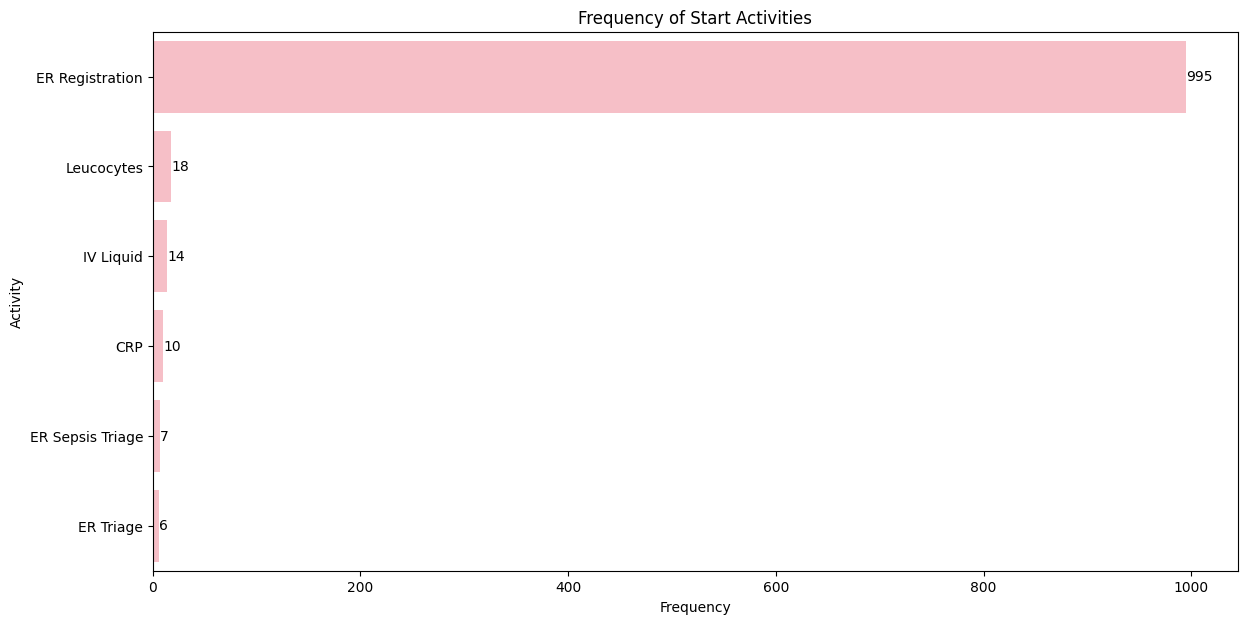

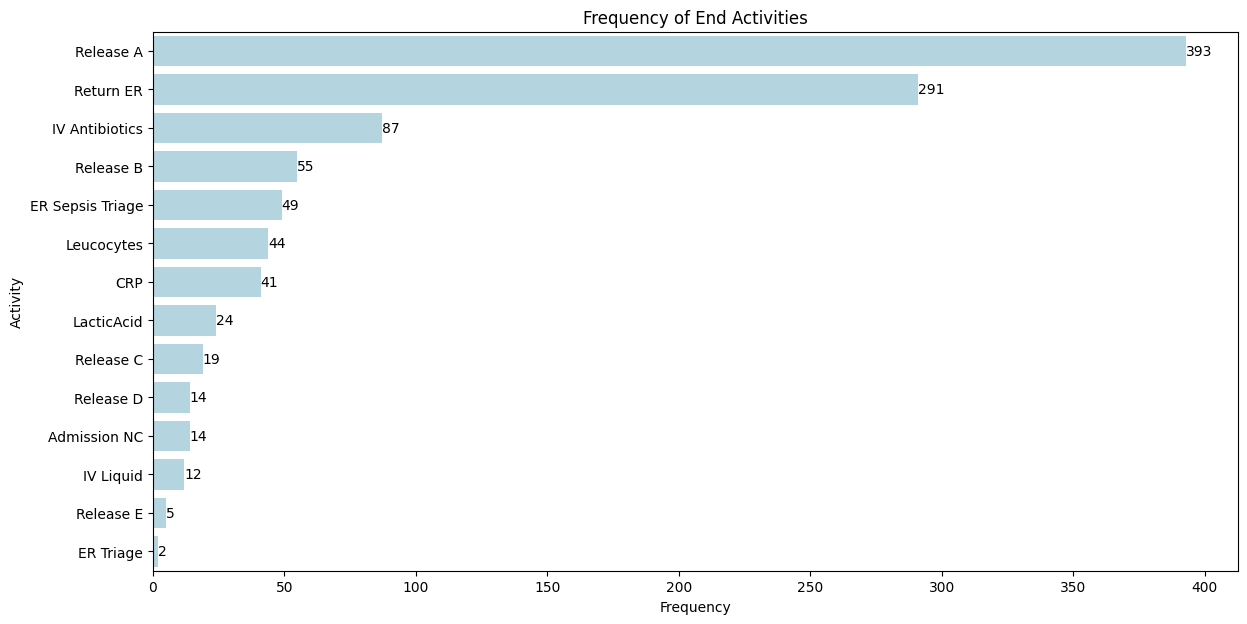

In [127]:
# Get start and end activities
start_activities = pm4py.get_start_activities(df)
end_activities = pm4py.get_end_activities(df)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

# Convert start activities to DataFrame
start_activities_df = pd.DataFrame(list(start_activities.items()), columns=['Activity', 'Frequency'])

# Convert end activities to DataFrame
end_activities_df = pd.DataFrame(list(end_activities.items()), columns=['Activity', 'Frequency'])

# Plot start activities
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Activity', data=start_activities_df.sort_values(by='Frequency', ascending=False), color='lightpink')
plt.title('Frequency of Start Activities')
plt.xlabel('Frequency')
plt.ylabel('Activity')

for index, value in enumerate(start_activities_df.sort_values(by='Frequency', ascending=False)['Frequency']):
    plt.text(value, index, str(value), va='center')

plt.show()

# Plot end activities
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Activity', data=end_activities_df.sort_values(by='Frequency', ascending=False), color='lightblue')
plt.title('Frequency of End Activities')
plt.xlabel('Frequency')
plt.ylabel('Activity')

for index, value in enumerate(end_activities_df.sort_values(by='Frequency', ascending=False)['Frequency']):
    plt.text(value, index, str(value), va='center')

plt.show()


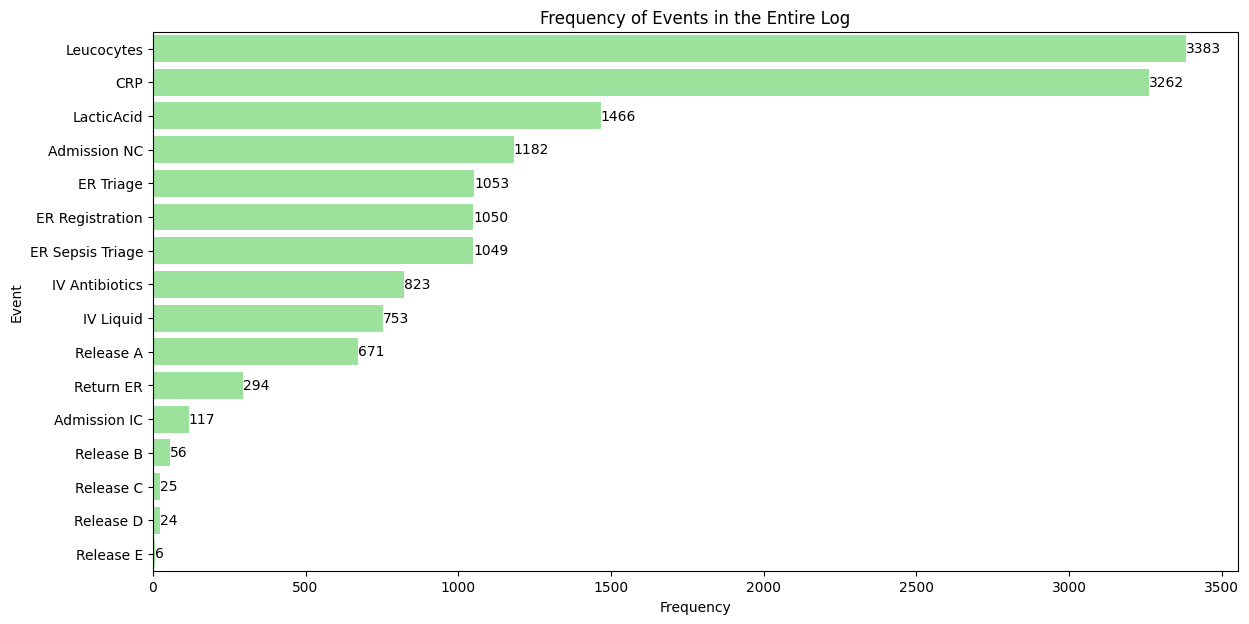

In [128]:
# Calculate the frequency of each event in the log
event_frequencies = df['concept:name'].value_counts()

# Convert event frequencies to DataFrame
event_frequencies_df = event_frequencies.reset_index()
event_frequencies_df.columns = ['Event', 'Frequency']

# Plot the most common events
plt.figure(figsize=(14, 7))
sns.barplot(x='Frequency', y='Event', data=event_frequencies_df.sort_values(by='Frequency', ascending=False), color='lightgreen')
plt.title('Frequency of Events in the Entire Log')
plt.xlabel('Frequency')
plt.ylabel('Event')

for index, value in enumerate(event_frequencies_df.sort_values(by='Frequency', ascending=False)['Frequency']):
    plt.text(value, index, str(value), va='center')

plt.show()

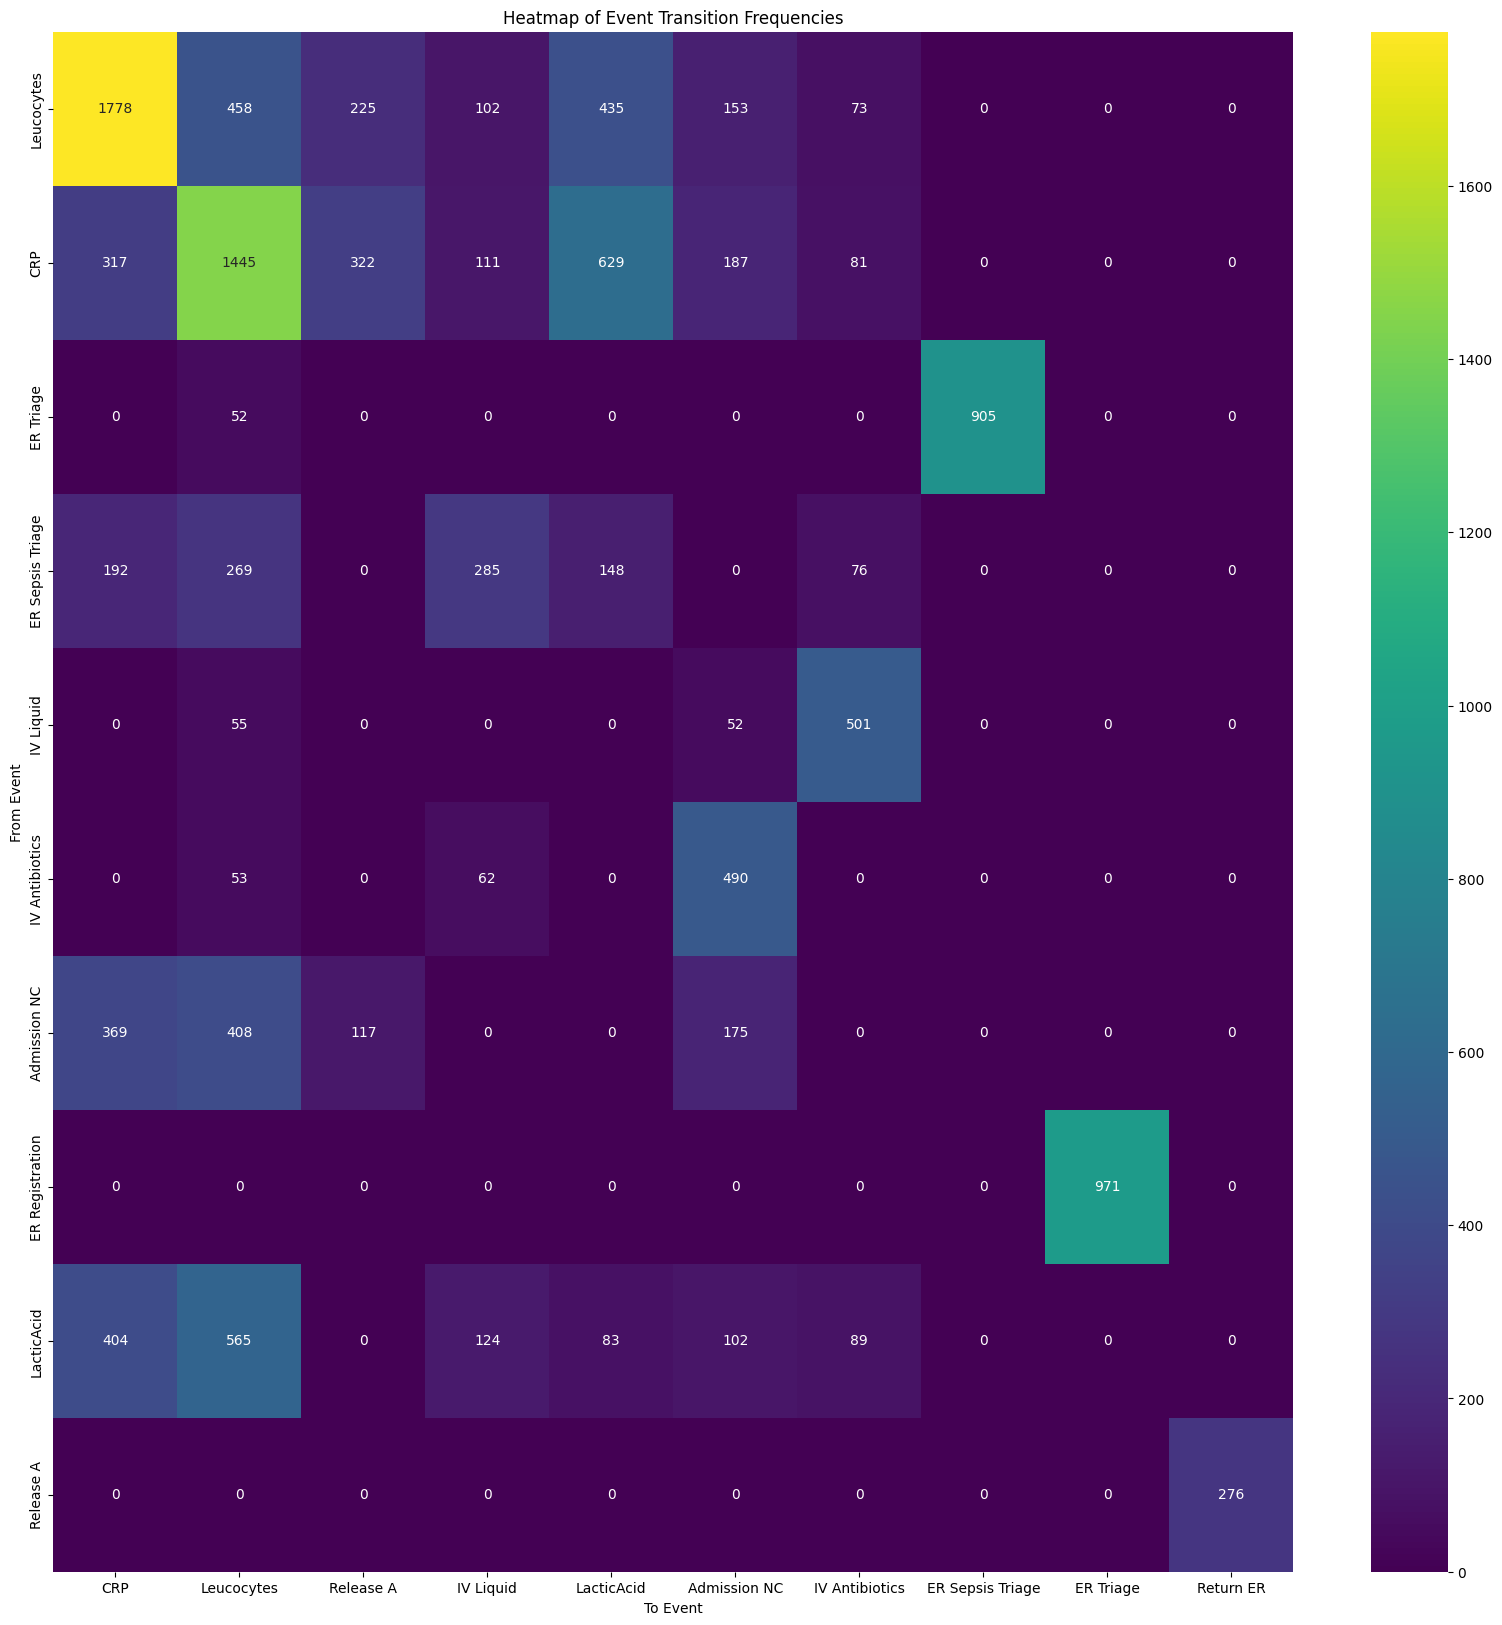

In [129]:
# Extract the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)

# Setting a threshold (reference point)
threshold = 50

# Filtering the dictionary to only include items with values above the threshold
filtered_dfg = {key: value for key, value in dfg.items() if value > threshold}

#empty dictionary to be converted to DataFrame
transition_matrix = {}
for (from_event, to_event), frequency in filtered_dfg.items():
    if from_event not in transition_matrix:
        transition_matrix[from_event] = {}
    transition_matrix[from_event][to_event] = frequency

# dataframe with the transition matrix
df_matrix = pd.DataFrame(transition_matrix).fillna(0).astype(int).T  # Transpose for correct orientation

# Create a mask for values below the threshold 
mask = df_matrix < 0

# plot the heatmap
plt.figure(figsize=(20, 20))  # Size may need adjustment based on the actual size of the matrix
sns.heatmap(df_matrix, mask=mask, annot=True, fmt='d', cmap='viridis')
plt.title('Heatmap of Event Transition Frequencies')
plt.xlabel('To Event')
plt.ylabel('From Event')
plt.show()


In [130]:
# Define thresholds for each segment
wbc_low_threshold = 4000
wbc_high_threshold = 12000
lactic_acid_high_threshold = 2.0
crp_threshold = 50

# Segment based on CRP > 50 mg/L
CasesCRPRisk = filtered_df[filtered_df['CRP'] >= crp_threshold]['case:concept:name'].unique()
segmentCRP50 = filtered_df[filtered_df['case:concept:name'].isin(CasesCRPRisk)]
print('Number of cases with CRP > 50:', len(CasesCRPRisk))

# Segment based on Leucocytes < 4000/μl or > 12000/μl
condition_leu = (filtered_df['Leucocytes'] < wbc_low_threshold) | (filtered_df['Leucocytes'] > wbc_high_threshold)
CasesLeuRisk = filtered_df[condition_leu]['case:concept:name'].unique()
segmentLeuRisk = filtered_df[filtered_df['case:concept:name'].isin(CasesLeuRisk)]
print('Number of cases with Leucocytes < 4000/μl or > 12000/μl:', len(CasesLeuRisk))

# Segment based on Lactic Acid > 2.0 µg/L
condition_lact_high = filtered_df['LacticAcid'] > lactic_acid_high_threshold
CasesLactRiskHigh = filtered_df[condition_lact_high]['case:concept:name'].unique()
segmentLactRiskHigh = filtered_df[filtered_df['case:concept:name'].isin(CasesLactRiskHigh)]
print('Number of cases with Lactic Acid > 2.0 µg/L:', len(CasesLactRiskHigh))



Number of cases with CRP > 50: 606
Number of cases with Leucocytes < 4000/μl or > 12000/μl: 719
Number of cases with Lactic Acid > 2.0 µg/L: 240


In [131]:
# Function to get start and end activities for a given segment
def get_start_end_activities(segment, segment_name):
    start_activities = pm4py.get_start_activities(segment)
    end_activities = pm4py.get_end_activities(segment)
    print(f"{segment_name} - Start activities: {start_activities}")
    print(f"{segment_name} - End activities: {end_activities}\n")
    return start_activities, end_activities

# Get start and end activities for each segment
start_activities_crp, end_activities_crp = get_start_end_activities(segmentCRP50, 'CRP > 50')
start_activities_leu, end_activities_leu = get_start_end_activities(segmentLeuRisk, 'Leucocytes Risk')
start_activities_lact, end_activities_lact = get_start_end_activities(segmentLactRiskHigh, 'Lactic Acid > 2.0')

# Get start and end activities for each segment
get_start_end_activities(segmentCRP50, 'CRP > 50')
get_start_end_activities(segmentLeuRisk, 'Leucocytes Risk')
get_start_end_activities(segmentLactRisk, 'Lactic Acid Risk')

CRP > 50 - Start activities: {'ER Registration': 598, 'ER Sepsis Triage': 5, 'ER Triage': 3}
CRP > 50 - End activities: {'Release A': 309, 'Return ER': 222, 'Release B': 45, 'Release C': 14, 'Release D': 13, 'Release E': 3}

Leucocytes Risk - Start activities: {'ER Registration': 710, 'ER Triage': 4, 'ER Sepsis Triage': 5}
Leucocytes Risk - End activities: {'Release A': 375, 'Return ER': 260, 'Release B': 50, 'Release C': 16, 'Release D': 13, 'Release E': 5}

Lactic Acid > 2.0 - Start activities: {'ER Registration': 235, 'ER Triage': 2, 'ER Sepsis Triage': 3}
Lactic Acid > 2.0 - End activities: {'Release A': 113, 'Release B': 24, 'Return ER': 95, 'Release D': 4, 'Release C': 3, 'Release E': 1}

CRP > 50 - Start activities: {'ER Registration': 598, 'ER Sepsis Triage': 5, 'ER Triage': 3}
CRP > 50 - End activities: {'Release A': 309, 'Return ER': 222, 'Release B': 45, 'Release C': 14, 'Release D': 13, 'Release E': 3}

Leucocytes Risk - Start activities: {'ER Registration': 710, 'ER Triage

({'ER Registration': 240, 'ER Triage': 3, 'ER Sepsis Triage': 3},
 {'Release A': 116,
  'Release B': 25,
  'Return ER': 97,
  'Release D': 4,
  'Release C': 3,
  'Release E': 1})


 Common activities for CRP > 50 - Start Activities (>= 200 occurrences):
          Activity  Count   Type   Segment
0  ER Registration    598  Start  CRP > 50

 Common activities for CRP > 50 - End Activities (>= 200 occurrences):
    Activity  Count Type   Segment
0  Release A    309  End  CRP > 50
1  Return ER    222  End  CRP > 50

 Common activities for Leucocytes Risk - Start Activities (>= 200 occurrences):
          Activity  Count   Type          Segment
0  ER Registration    710  Start  Leucocytes Risk

 Common activities for Leucocytes Risk - End Activities (>= 200 occurrences):
    Activity  Count Type          Segment
0  Release A    375  End  Leucocytes Risk
1  Return ER    260  End  Leucocytes Risk

 Common activities for Lactic Acid Risk - Start Activities (>= 200 occurrences):
          Activity  Count   Type           Segment
0  ER Registration    235  Start  Lactic Acid Risk

 Common activities for Lactic Acid Risk - End Activities (>= 200 occurrences):
Empty DataFra

/var/folders/5x/8_jh2mhj6g9_30_6jg_nqzxc0000gn/T/ipykernel_81980/3635718281.py:45: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  start_plot = sns.barplot(data=start_activities_df, x='Segment', y='Count', hue='Activity', palette=lightblue_palette, ci=None)


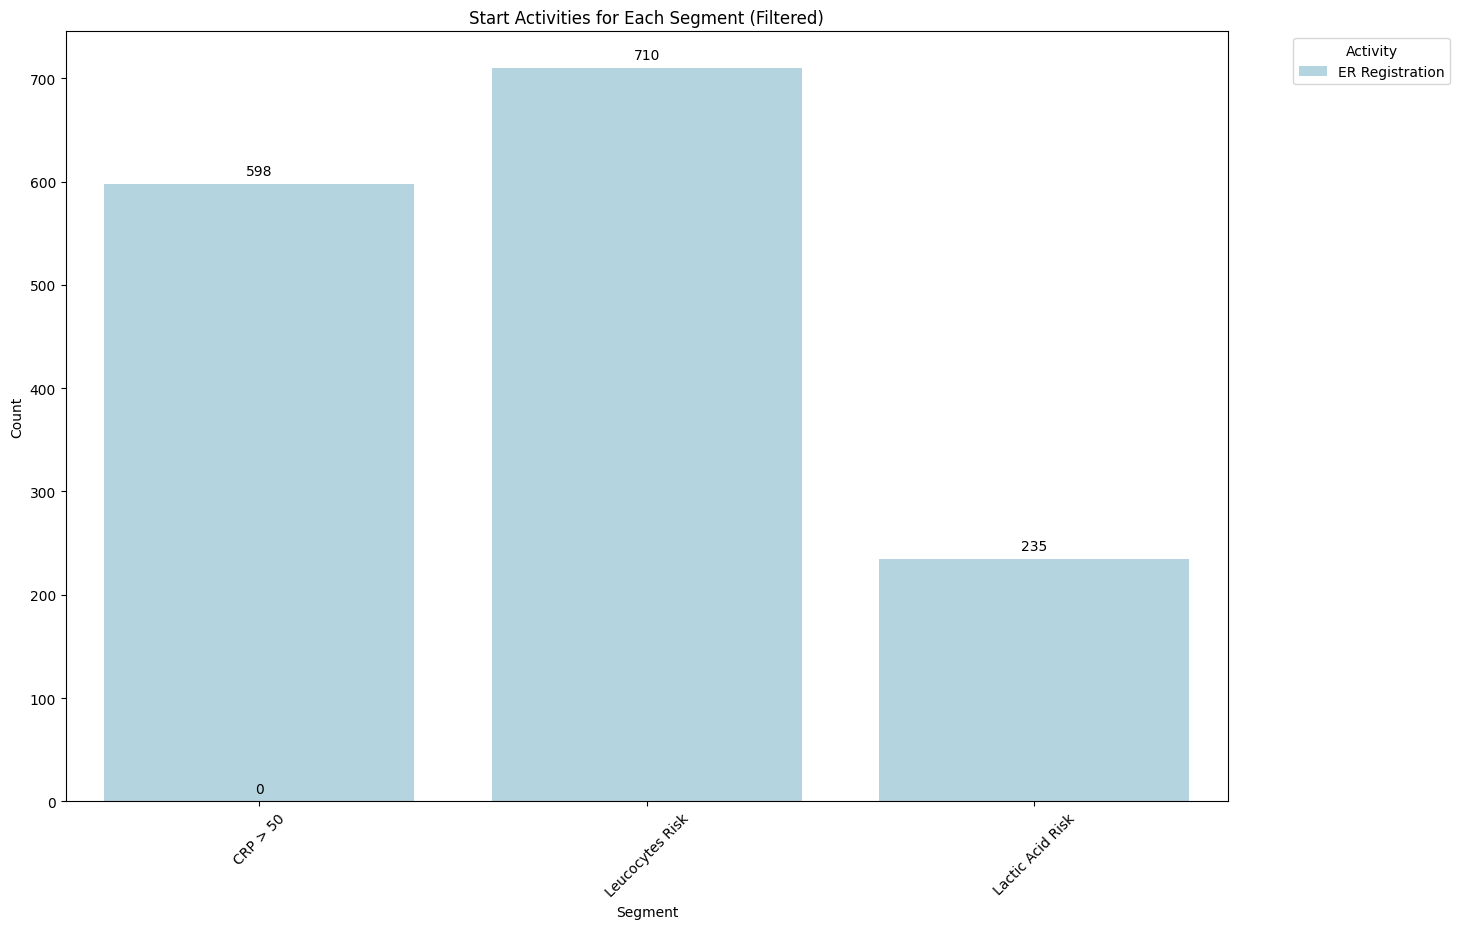

/var/folders/5x/8_jh2mhj6g9_30_6jg_nqzxc0000gn/T/ipykernel_81980/3635718281.py:64: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  end_plot = sns.barplot(data=end_activities_df, x='Segment', y='Count', hue='Activity', palette=lightpink_palette, ci=None)


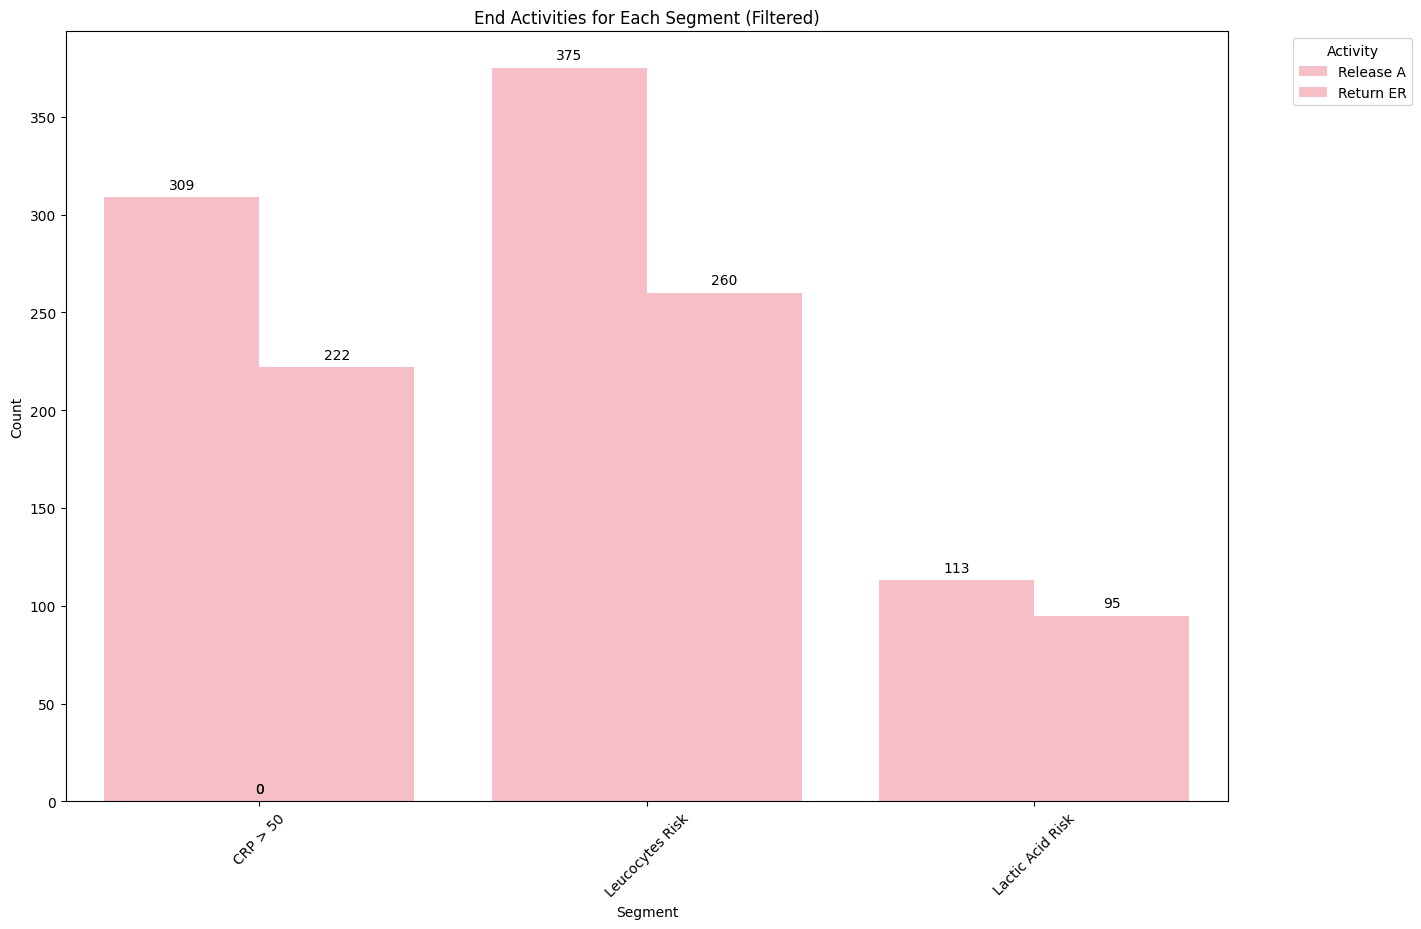

In [140]:
# Convert activities to DataFrames
def activities_to_dataframe(activities, segment_name, activity_type):
    df = pd.DataFrame(list(activities.items()), columns=['Activity', 'Count'])
    df['Type'] = activity_type
    df['Segment'] = segment_name
    return df

# Prepare dataframes for plotting
start_crp_df = activities_to_dataframe(start_activities_crp, 'CRP > 50', 'Start')
end_crp_df = activities_to_dataframe(end_activities_crp, 'CRP > 50', 'End')
start_leu_df = activities_to_dataframe(start_activities_leu, 'Leucocytes Risk', 'Start')
end_leu_df = activities_to_dataframe(end_activities_leu, 'Leucocytes Risk', 'End')
start_lact_df = activities_to_dataframe(start_activities_lact, 'Lactic Acid Risk', 'Start')
end_lact_df = activities_to_dataframe(end_activities_lact, 'Lactic Acid Risk', 'End')

# Combine all start and end activities dataframes
start_activities_df = pd.concat([start_crp_df, start_leu_df, start_lact_df])
end_activities_df = pd.concat([end_crp_df, end_leu_df, end_lact_df])

# Filter activities with less than 200 occurrences for start activities
start_activities_df = start_activities_df[start_activities_df['Count'] >= 200]

# Filter activities with less than 90 occurrences for end activities
end_activities_df = end_activities_df[end_activities_df['Count'] >= 90]

# Define custom color palettes
lightblue_palette = sns.color_palette(["#ADD8E6"] * len(start_activities_df['Activity'].unique()))
lightpink_palette = sns.color_palette(["#FFB6C1"] * len(end_activities_df['Activity'].unique()))

# Plotting already covered, here's how to interpret
def interpret_activities(activity_df, segment_name):
    common_activities = activity_df[activity_df['Count'] >= 200]
    print(f'\n Common activities for {segment_name} (>= 200 occurrences):')
    print(common_activities)

interpret_activities(start_crp_df, 'CRP > 50 - Start Activities')
interpret_activities(end_crp_df, 'CRP > 50 - End Activities')
interpret_activities(start_leu_df, 'Leucocytes Risk - Start Activities')
interpret_activities(end_leu_df, 'Leucocytes Risk - End Activities')
interpret_activities(start_lact_df, 'Lactic Acid Risk - Start Activities')
interpret_activities(end_lact_df, 'Lactic Acid Risk - End Activities')

# Plot Start Activities
plt.figure(figsize=(15, 10))
start_plot = sns.barplot(data=start_activities_df, x='Segment', y='Count', hue='Activity', palette=lightblue_palette, ci=None)
plt.title('Start Activities for Each Segment (Filtered)')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add labels to the bars
for p in start_plot.patches:
    start_plot.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 9),
                        textcoords='offset points')

plt.show()

# Plot End Activities
plt.figure(figsize=(15, 10))
end_plot = sns.barplot(data=end_activities_df, x='Segment', y='Count', hue='Activity', palette=lightpink_palette, ci=None)
plt.title('End Activities for Each Segment (Filtered)')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# Add labels to the bars
for p in end_plot.patches:
    end_plot.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 9),
                      textcoords='offset points')

plt.show()


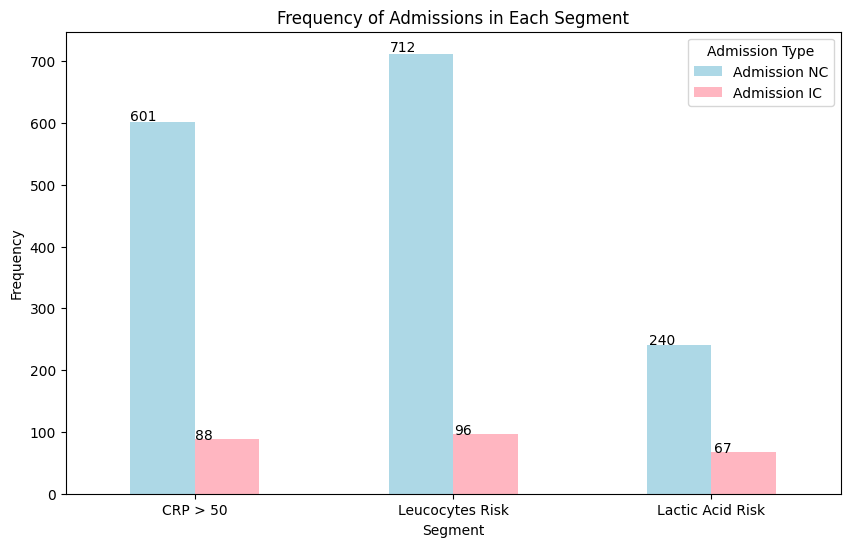

In [133]:
# Function to calculate frequency of admissions
def calculate_admission_frequencies(segment_df):
    admission_nc_freq = segment_df[segment_df['concept:name'] == 'Admission NC']['case:concept:name'].nunique()
    admission_ic_freq = segment_df[segment_df['concept:name'] == 'Admission IC']['case:concept:name'].nunique()
    return admission_nc_freq, admission_ic_freq

# Calculate frequencies for each segment
admission_nc_crp, admission_ic_crp = calculate_admission_frequencies(segmentCRP50)
admission_nc_leu, admission_ic_leu = calculate_admission_frequencies(segmentLeuRisk)
admission_nc_lact, admission_ic_lact = calculate_admission_frequencies(segmentLactRisk)

# Prepare data for visualization
data = {
    'Segment': ['CRP > 50', 'Leucocytes Risk', 'Lactic Acid Risk'],
    'Admission NC': [admission_nc_crp, admission_nc_leu, admission_nc_lact],
    'Admission IC': [admission_ic_crp, admission_ic_leu, admission_ic_lact]
}

# Create DataFrame
admissions_df = pd.DataFrame(data)

# Plot the frequencies
ax = admissions_df.set_index('Segment').plot(kind='bar', figsize=(10, 6), color=['lightblue', 'lightpink'])
plt.title('Frequency of Admissions in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Admission Type')

# Add labels to the bars
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

In [ ]:
# Convert the filtered dataframes back to event logs
log_crp = pm4py.convert_to_event_log(segmentCRP50)
log_leu = pm4py.convert_to_event_log(segmentLeuRisk)
log_lact = pm4py.convert_to_event_log(segmentLactRisk)

# Discover BPMN model for each segment
bpmn_model_crp = pm4py.discover_bpmn_inductive(log_crp)
bpmn_model_leu = pm4py.discover_bpmn_inductive(log_leu)
bpmn_model_lact = pm4py.discover_bpmn_inductive(log_lact)

# Save the BPMN model visualizations
pm4py.save_vis_bpmn(bpmn_model_crp, 'bpmn_model_crp.png')
pm4py.save_vis_bpmn(bpmn_model_leu, 'bpmn_model_leu.png')
pm4py.save_vis_bpmn(bpmn_model_lact, 'bpmn_model_lact.png')

print("BPMN diagrams saved for each segment.")

In [ ]:
# Discover Petri nets for each segment
net_crp, im_crp, fm_crp = discover_petri_net_inductive(log_crp)
net_leu, im_leu, fm_leu = discover_petri_net_inductive(log_leu)
net_lact, im_lact, fm_lact = discover_petri_net_inductive(log_lact)

# Function to visualize and save Petri net
def visualize_petri_net(net, im, fm, title):
    gviz = pm4py.view_petri_net(net, im, fm, format='png')
    pm4py.save_vis_petri_net(net, im, fm, f"{title}.png")
    return gviz

# Visualize and save Petri nets
gviz_crp = visualize_petri_net(net_crp, im_crp, fm_crp, "CRP > 50 Petri Net")
gviz_leu = visualize_petri_net(net_leu, im_leu, fm_leu, "Leucocytes Risk Petri Net")
gviz_lact = visualize_petri_net(net_lact, im_lact, fm_lact, "Lactic Acid Risk Petri Net")

print("Petri nets saved for each segment.")

In [ ]:
# Function to discover and save BPMN model for a given event log and segment name
def discover_and_save_bpmn(event_log, segment_name):
    # Discover BPMN model
    bpmn_model = pm4py.discover_bpmn_inductive(event_log)
    
    # Save BPMN model visualization
    bpmn_file_path = f'bpmn_model_{segment_name}.png'
    pm4py.save_vis_bpmn(bpmn_model, bpmn_file_path)
    
    print(f"BPMN model saved for {segment_name} at {bpmn_file_path}")

# Discover and save BPMN models for each segment
discover_and_save_bpmn(log_crp, 'CRP > 50')
discover_and_save_bpmn(log_leu, 'Leucocytes Risk')
discover_and_save_bpmn(log_lact, 'Lactic Acid Risk')

print("BPMN models generated and saved for each segment.")

In [ ]:
# Function to discover Petri net using Alpha Miner
def discover_petri_net_alpha(log):
    net, im, fm = pm4py.discover_petri_net_alpha(log)
    return net, im, fm

# Discover Petri nets for each segment
net_crp, im_crp, fm_crp = discover_petri_net_alpha(event_log_crp)
net_leu, im_leu, fm_leu = discover_petri_net_alpha(event_log_leu)
net_lact, im_lact, fm_lact = discover_petri_net_alpha(event_log_lact)


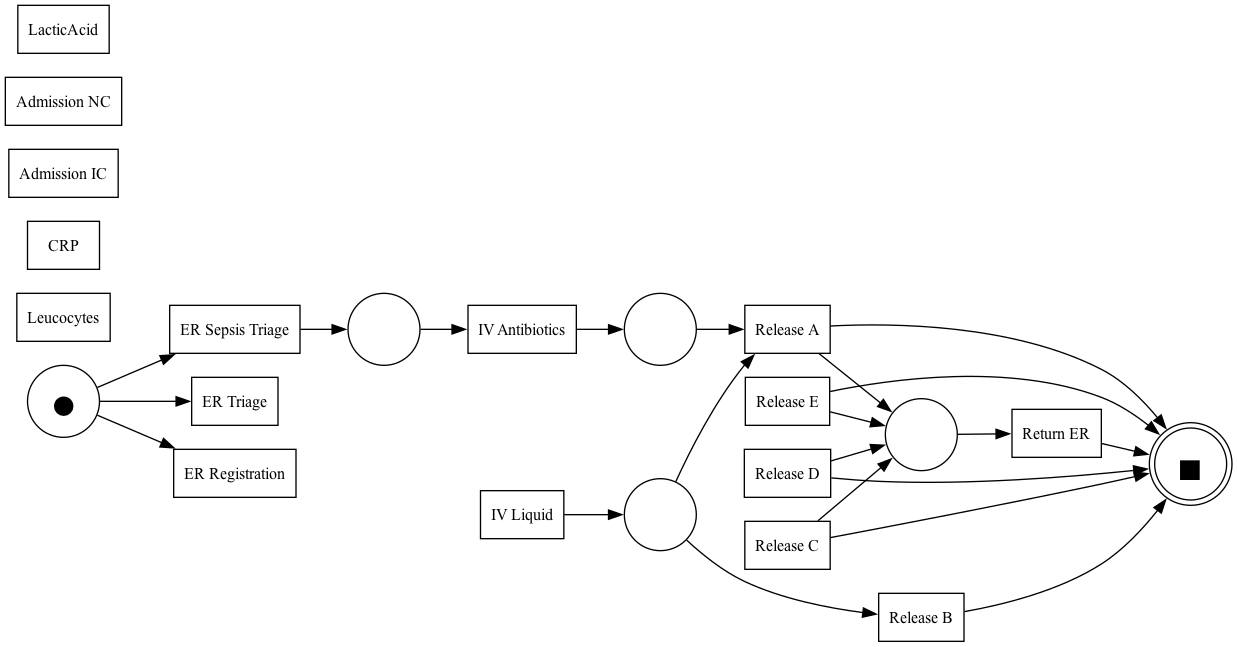

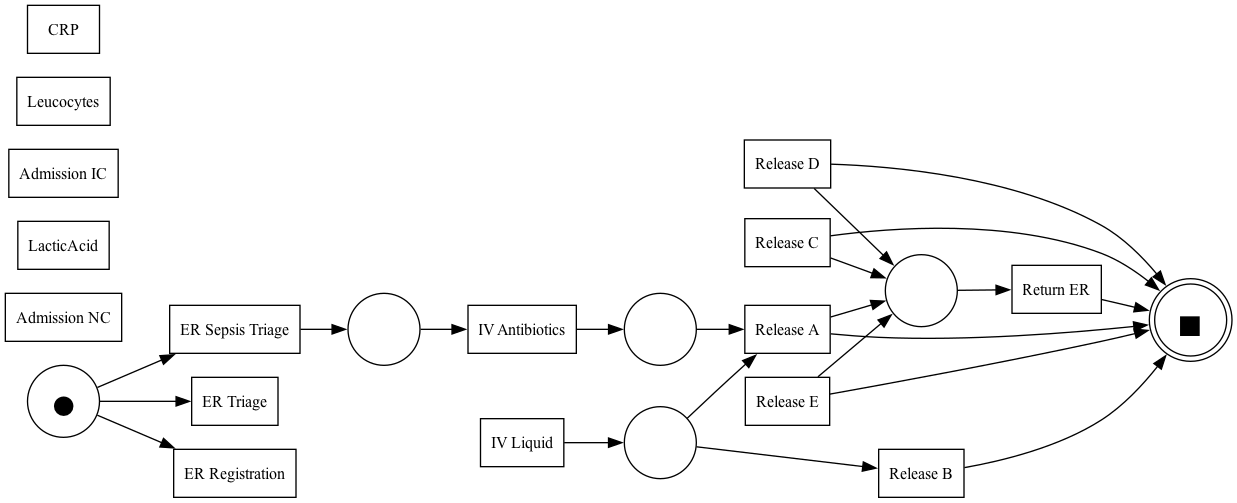

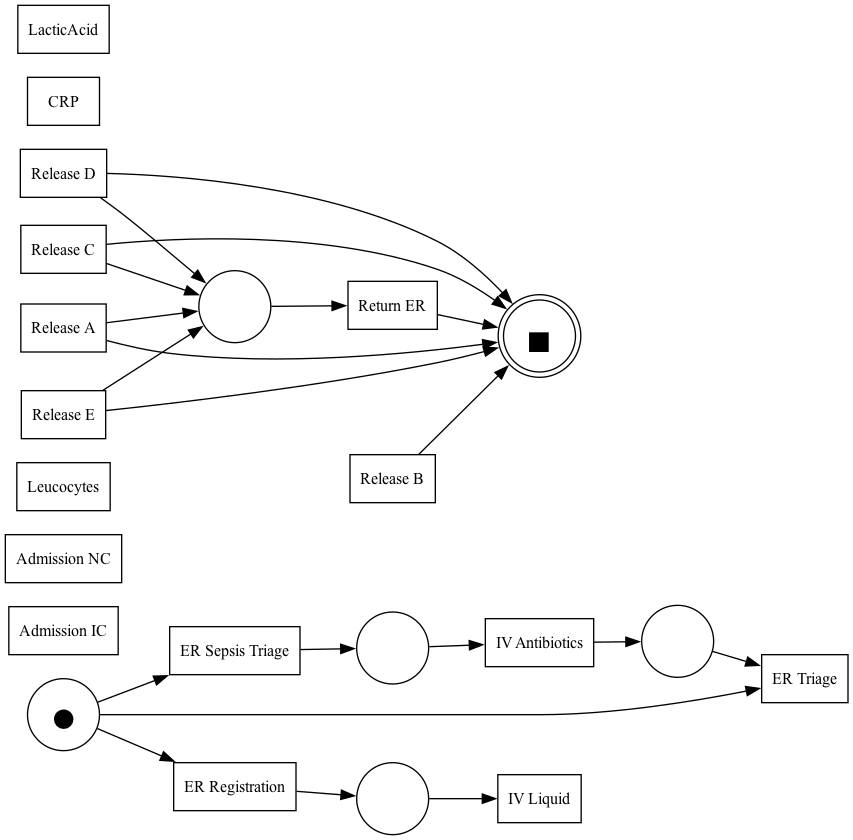

In [117]:
# Function to visualize Petri net
def visualize_petri_net(net, im, fm, title):
    gviz = pm4py.view_petri_net(net, im, fm, format='png')
    pm4py.save_vis_petri_net(net, im, fm, f"{title}.png")
    return gviz

# Visualize and save Petri nets
gviz_crp = visualize_petri_net(net_crp, im_crp, fm_crp, "CRP > 50 Petri Net")
gviz_leu = visualize_petri_net(net_leu, im_leu, fm_leu, "Leucocytes Risk Petri Net")
gviz_lact = visualize_petri_net(net_lact, im_lact, fm_lact, "Lactic Acid Risk Petri Net")


In [118]:
# Function to count activity frequencies in a segment
def count_activity_frequencies(segment, segment_name):
    activity_counts = segment['concept:name'].value_counts()
    print(f"{segment_name} - Activity frequencies:\n{activity_counts}\n")
    return activity_counts

# Count activity frequencies for each segment
activity_counts_crp = count_activity_frequencies(segmentCRP50, 'CRP > 50')
activity_counts_leu = count_activity_frequencies(segmentLeuRisk, 'Leucocytes Risk')
activity_counts_lact = count_activity_frequencies(segmentLactRiskHigh, 'Lactic Acid > 2.0')

# Combine activity frequencies into a DataFrame for comparison
combined_activity_counts = pd.DataFrame({
    'CRP > 50': activity_counts_crp,
    'Leucocytes Risk': activity_counts_leu,
    'Lactic Acid > 2.0': activity_counts_lact
}).fillna(0).astype(int)

print("Combined activity frequencies across segments:\n", combined_activity_counts)

# Identify common activities across segments
common_activities = combined_activity_counts[(combined_activity_counts['CRP > 50'] > 0) & 
                                             (combined_activity_counts['Leucocytes Risk'] > 0) & 
                                             (combined_activity_counts['Lactic Acid > 2.0'] > 0)]
print("Common activities across all segments:\n", common_activities)

CRP > 50 - Activity frequencies:
concept:name
Leucocytes          2569
CRP                 2537
LacticAcid          1089
Admission NC         925
ER Triage            607
ER Registration      606
ER Sepsis Triage     605
IV Antibiotics       555
Release A            518
IV Liquid            511
Return ER            222
Admission IC          92
Release B             45
Release D             21
Release C             18
Release E              4
Name: count, dtype: int64

Leucocytes Risk - Activity frequencies:
concept:name
Leucocytes          2824
CRP                 2738
LacticAcid          1195
Admission NC        1067
ER Triage            720
ER Registration      719
ER Sepsis Triage     718
IV Antibiotics       626
Release A            618
IV Liquid            574
Return ER            260
Admission IC         101
Release B             50
Release D             23
Release C             22
Release E              6
Name: count, dtype: int64

Lactic Acid > 2.0 - Activity frequencies:
conce

<Figure size 1400x800 with 0 Axes>

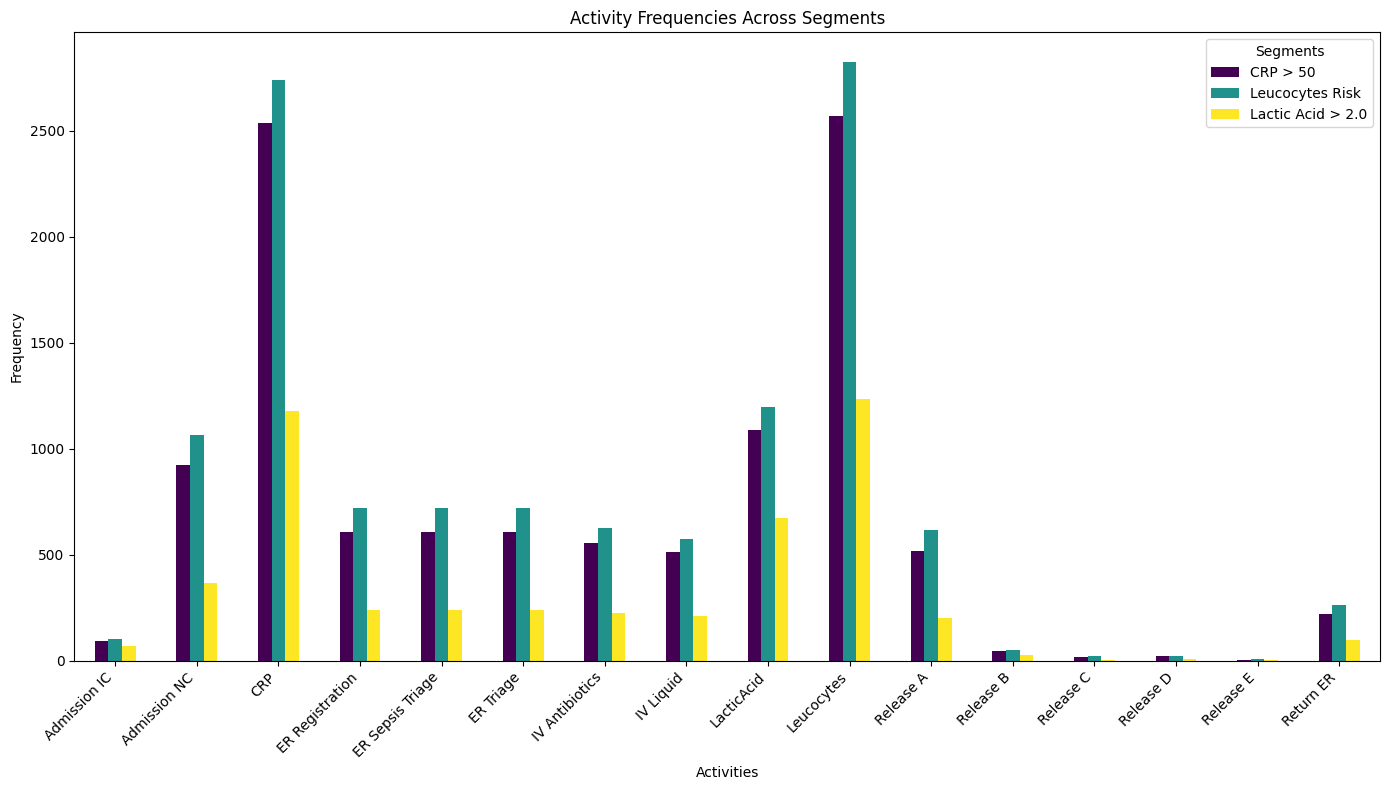

In [119]:
import matplotlib.pyplot as plt

# Plot combined activity frequencies across segments
plt.figure(figsize=(14, 8))
combined_activity_counts.plot(kind='bar', figsize=(14, 8), colormap='viridis')

plt.title('Activity Frequencies Across Segments')
plt.xlabel('Activities')
plt.ylabel('Frequency')
plt.legend(title='Segments')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot to a file
plt.savefig('activity_frequencies_across_segments.png', format='png', dpi=300)

plt.show()
